# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

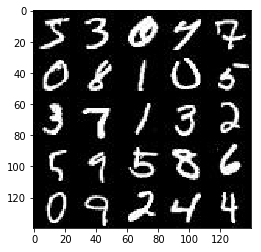

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

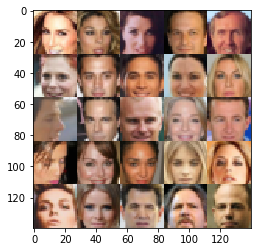

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/Users/azazdeaz/anaconda/envs/dlnd/lib/python3.6/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [17]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32, (None, image_height, image_width, image_channels), name='real_input')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [18]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
      def conv(inp, filters, kernel_size, strides):
        return tf.layers.conv2d(inp, filters, kernel_size, strides=strides, padding='same')
      
      def activate(inp):
        norm = tf.layers.batch_normalization(inp, training=True)
        return tf.maximum(norm * 0.2, norm)
      
      images = conv(images, 64, 5, 2)
      images = activate(images)
      images = conv(images, 128, 5, 2)
      images = activate(images)
      images = conv(images, 256, 5, 2)
      logits = tf.layers.dense(tf.contrib.layers.flatten(images), 1)
      out = tf.nn.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [46]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
      def conv(inp, filters, kernel_size, strides, padding='same'):
        return tf.layers.conv2d_transpose(inp, filters, kernel_size, strides=strides, padding=padding)

      def activate(inp):
        norm = tf.layers.batch_normalization(inp, training=is_train)
#         return tf.nn.relu(norm)
        return tf.maximum(norm * 0.2, norm)

      images = tf.layers.dense(z, 4*4*512, use_bias=False)
      images = tf.reshape(images, (-1, 4, 4, 512))
      images = activate(images)
      images = conv(images, 256, 5, 2, 'valid')
      images = activate(images)
      images = conv(images, 128, 5, 2)
      images = activate(images)

      images = conv(images, 64, 3, 1, 'valid')
      images = activate(images)
      images = conv(images, out_channel_dim, 5, 1, 'valid')
      images = tf.nn.tanh(images)
#       images = conv(images, out_channel_dim, 4, 1, 'valid')
#       images = tf.image.resize_images(images, (28,28), tf.image.ResizeMethod.NEAREST_NEIGHBOR)
      
#       print('the generator returns the shape {}'.format(images.get_shape().as_list()))
    
    return images


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [47]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    def loss(logits, label):
      labels = tf.ones_like(logits) * label
      return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))
      
    input_fake = generator(input_z, out_channel_dim, is_train=True)
    real_out, real_logits = discriminator(input_real, reuse=False)
    fake_out, fake_logits = discriminator(input_fake, reuse=True)
    
    d_loss = loss(real_logits, 1) + loss(fake_logits, 0)
    g_loss = loss(fake_logits, 1)
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [48]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    trainables = tf.trainable_variables()
    g_vars = [var for var in trainables if var.name.startswith('generator')]
    d_vars = [var for var in trainables if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collections(tf.GraphKeys.UPDATE_OPS)):
      g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
      d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
      return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [49]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])
    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [50]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    _, height, width, channels = data_shape
    log_freq = 32
    show_freq = 128
    batch_i = 0
    
    with tf.Session() as sess:
        p_real_inp, p_z_inp, p_learning_rate = model_inputs(height, width, channels, z_dim)
        d_loss, g_loss = model_loss(p_real_inp, p_z_inp, channels)
        d_opt, g_opt = model_opt(d_loss, g_loss, p_learning_rate, beta1)
        
        sess.run(tf.global_variables_initializer())
        
        show_generator_output(sess, 16, p_z_inp, channels, data_image_mode)
        
        def print_loss(epoch_i, batch_i):
            d_loss_ = sess.run(d_loss, {p_real_inp: batch_images, p_z_inp: z_inp})
            g_loss_ = sess.run(g_loss, {p_z_inp: z_inp})
            print('Epoch: {}/{}'.format(epoch_i, epoch_count),
                  'Batch: {}'.format(batch_i),
                  'Discriminator loss: {:.4f}'.format(d_loss_),
                  'Generator loss: {:.4f}'.format(g_loss_))
          
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                z_inp = np.random.uniform(-1, 1, (batch_images.shape[0], z_dim))
                z_inp2 = np.random.uniform(-1, 1, (batch_images.shape[0] * 2, z_dim))
                sess.run(d_opt, {p_learning_rate: learning_rate, 
                                 p_real_inp: batch_images,
                                 p_z_inp: z_inp})
                sess.run(g_opt, {p_learning_rate: learning_rate, 
                                 p_z_inp: z_inp})
                sess.run(g_opt, {p_learning_rate: learning_rate, 
                                 p_z_inp: z_inp2})
                
                batch_i += 1
                if (batch_i % log_freq == 0):
                    print_loss(epoch_i, batch_i)
                if (batch_i % show_freq == 0):
                    show_generator_output(sess, 16, p_z_inp, channels, data_image_mode)
        
        print('Finished training')
        print_loss(epoch_i, batch_i)
        show_generator_output(sess, 16, p_z_inp, channels, data_image_mode)
                
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)


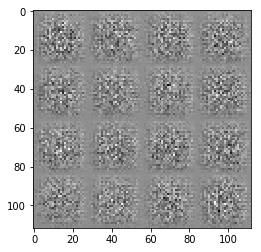

Epoch: 0/2 Batch: 32 Discriminator loss: 2.0164 Generator loss: 0.4042
Epoch: 0/2 Batch: 64 Discriminator loss: 3.1006 Generator loss: 0.7837
Epoch: 0/2 Batch: 96 Discriminator loss: 1.4258 Generator loss: 0.6491
Epoch: 0/2 Batch: 128 Discriminator loss: 1.7921 Generator loss: 0.7258


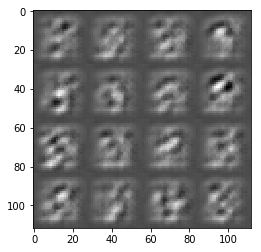

Epoch: 0/2 Batch: 160 Discriminator loss: 1.5182 Generator loss: 0.6889
Epoch: 0/2 Batch: 192 Discriminator loss: 1.2133 Generator loss: 0.8262
Epoch: 0/2 Batch: 224 Discriminator loss: 1.6475 Generator loss: 0.5716
Epoch: 0/2 Batch: 256 Discriminator loss: 1.2724 Generator loss: 0.6253


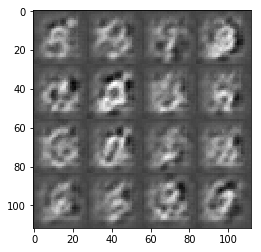

Epoch: 0/2 Batch: 288 Discriminator loss: 1.7542 Generator loss: 0.5154
Epoch: 0/2 Batch: 320 Discriminator loss: 1.2931 Generator loss: 1.0643
Epoch: 0/2 Batch: 352 Discriminator loss: 1.5743 Generator loss: 1.0106
Epoch: 0/2 Batch: 384 Discriminator loss: 1.3242 Generator loss: 0.6750


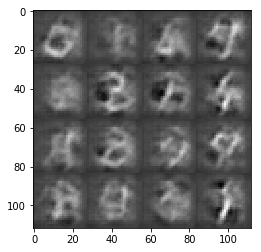

Epoch: 0/2 Batch: 416 Discriminator loss: 1.5174 Generator loss: 1.0605
Epoch: 0/2 Batch: 448 Discriminator loss: 1.4093 Generator loss: 1.0525
Epoch: 1/2 Batch: 480 Discriminator loss: 1.3706 Generator loss: 0.8294
Epoch: 1/2 Batch: 512 Discriminator loss: 1.3634 Generator loss: 0.5903


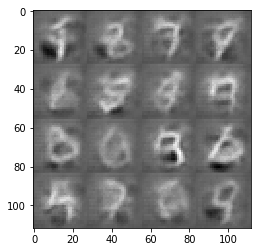

Epoch: 1/2 Batch: 544 Discriminator loss: 1.4691 Generator loss: 0.4695
Epoch: 1/2 Batch: 576 Discriminator loss: 1.3915 Generator loss: 0.8210
Epoch: 1/2 Batch: 608 Discriminator loss: 1.4640 Generator loss: 0.5269
Epoch: 1/2 Batch: 640 Discriminator loss: 1.3603 Generator loss: 0.5227


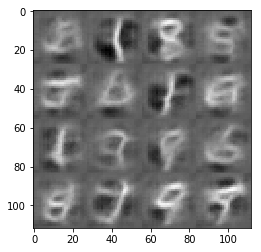

Epoch: 1/2 Batch: 672 Discriminator loss: 1.2934 Generator loss: 0.7778
Epoch: 1/2 Batch: 704 Discriminator loss: 1.3974 Generator loss: 0.5495
Epoch: 1/2 Batch: 736 Discriminator loss: 1.5285 Generator loss: 1.2944
Epoch: 1/2 Batch: 768 Discriminator loss: 1.3302 Generator loss: 0.7534


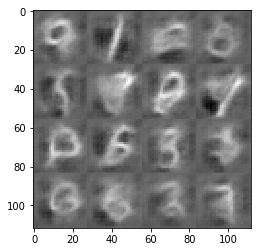

Epoch: 1/2 Batch: 800 Discriminator loss: 1.4415 Generator loss: 0.7196
Epoch: 1/2 Batch: 832 Discriminator loss: 1.4131 Generator loss: 0.4879
Epoch: 1/2 Batch: 864 Discriminator loss: 1.4614 Generator loss: 0.3980
Epoch: 1/2 Batch: 896 Discriminator loss: 1.4457 Generator loss: 0.4416


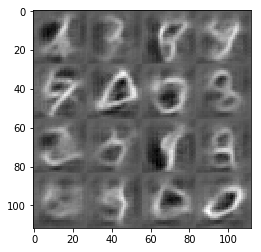

Epoch: 1/2 Batch: 928 Discriminator loss: 1.4230 Generator loss: 0.9465
Finished training
Epoch: 1/2 Batch: 936 Discriminator loss: 1.4172 Generator loss: 0.9496


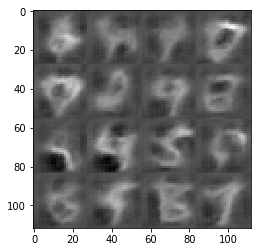

In [51]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
print(mnist_dataset.shape)
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

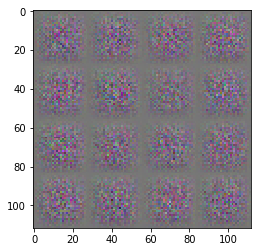

Epoch: 0/1 Batch: 32 Discriminator loss: 2.7769 Generator loss: 0.7799
Epoch: 0/1 Batch: 64 Discriminator loss: 2.3018 Generator loss: 0.8520
Epoch: 0/1 Batch: 96 Discriminator loss: 3.6909 Generator loss: 0.0768
Epoch: 0/1 Batch: 128 Discriminator loss: 1.6685 Generator loss: 0.3687


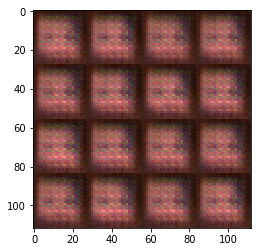

Epoch: 0/1 Batch: 160 Discriminator loss: 1.1028 Generator loss: 1.1866
Epoch: 0/1 Batch: 192 Discriminator loss: 1.1126 Generator loss: 2.1118
Epoch: 0/1 Batch: 224 Discriminator loss: 1.9401 Generator loss: 1.1209
Epoch: 0/1 Batch: 256 Discriminator loss: 0.9333 Generator loss: 1.0574


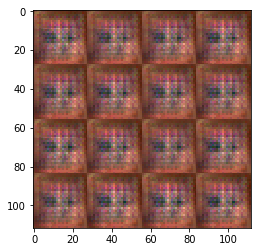

Epoch: 0/1 Batch: 288 Discriminator loss: 1.5276 Generator loss: 0.6097
Epoch: 0/1 Batch: 320 Discriminator loss: 1.0012 Generator loss: 1.3538
Epoch: 0/1 Batch: 352 Discriminator loss: 1.4023 Generator loss: 0.9574
Epoch: 0/1 Batch: 384 Discriminator loss: 2.5883 Generator loss: 0.4031


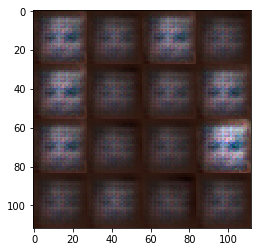

Epoch: 0/1 Batch: 416 Discriminator loss: 1.8291 Generator loss: 0.7596
Epoch: 0/1 Batch: 448 Discriminator loss: 1.7924 Generator loss: 0.6959
Epoch: 0/1 Batch: 480 Discriminator loss: 2.3514 Generator loss: 0.4497
Epoch: 0/1 Batch: 512 Discriminator loss: 1.6770 Generator loss: 0.7020


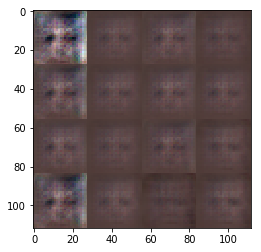

Epoch: 0/1 Batch: 544 Discriminator loss: 1.7708 Generator loss: 0.5643
Epoch: 0/1 Batch: 576 Discriminator loss: 1.6443 Generator loss: 0.5760
Epoch: 0/1 Batch: 608 Discriminator loss: 1.7669 Generator loss: 0.6053
Epoch: 0/1 Batch: 640 Discriminator loss: 1.6349 Generator loss: 0.5721


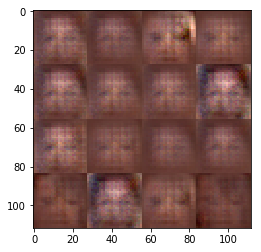

Epoch: 0/1 Batch: 672 Discriminator loss: 1.4437 Generator loss: 0.7376
Epoch: 0/1 Batch: 704 Discriminator loss: 1.6073 Generator loss: 0.5722
Epoch: 0/1 Batch: 736 Discriminator loss: 1.5576 Generator loss: 0.5816
Epoch: 0/1 Batch: 768 Discriminator loss: 1.6617 Generator loss: 0.6830


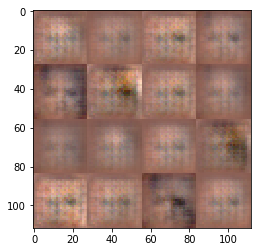

Epoch: 0/1 Batch: 800 Discriminator loss: 1.5699 Generator loss: 0.6672
Epoch: 0/1 Batch: 832 Discriminator loss: 1.5367 Generator loss: 0.6660
Epoch: 0/1 Batch: 864 Discriminator loss: 1.4011 Generator loss: 0.6846
Epoch: 0/1 Batch: 896 Discriminator loss: 1.4682 Generator loss: 0.7304


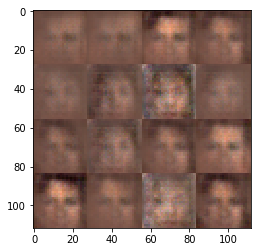

Epoch: 0/1 Batch: 928 Discriminator loss: 1.4726 Generator loss: 0.6375
Epoch: 0/1 Batch: 960 Discriminator loss: 1.5870 Generator loss: 0.6194
Epoch: 0/1 Batch: 992 Discriminator loss: 1.7000 Generator loss: 0.5919
Epoch: 0/1 Batch: 1024 Discriminator loss: 1.5648 Generator loss: 0.6493


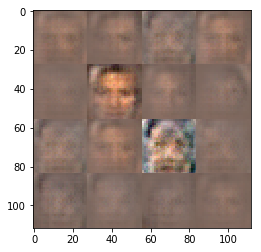

Epoch: 0/1 Batch: 1056 Discriminator loss: 1.4977 Generator loss: 0.7037
Epoch: 0/1 Batch: 1088 Discriminator loss: 1.4921 Generator loss: 0.6740
Epoch: 0/1 Batch: 1120 Discriminator loss: 1.5069 Generator loss: 0.6776
Epoch: 0/1 Batch: 1152 Discriminator loss: 1.6394 Generator loss: 0.6172


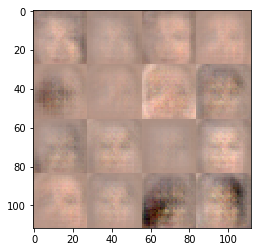

Epoch: 0/1 Batch: 1184 Discriminator loss: 1.5149 Generator loss: 0.6484
Epoch: 0/1 Batch: 1216 Discriminator loss: 1.5422 Generator loss: 0.6459
Epoch: 0/1 Batch: 1248 Discriminator loss: 1.4507 Generator loss: 0.6818
Epoch: 0/1 Batch: 1280 Discriminator loss: 1.5593 Generator loss: 0.6501


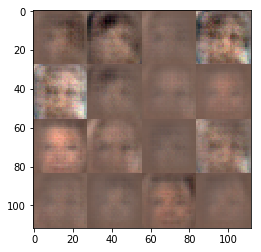

Epoch: 0/1 Batch: 1312 Discriminator loss: 1.5190 Generator loss: 0.6580
Epoch: 0/1 Batch: 1344 Discriminator loss: 1.4767 Generator loss: 0.6628
Epoch: 0/1 Batch: 1376 Discriminator loss: 1.4832 Generator loss: 0.6352
Epoch: 0/1 Batch: 1408 Discriminator loss: 1.5164 Generator loss: 0.6794


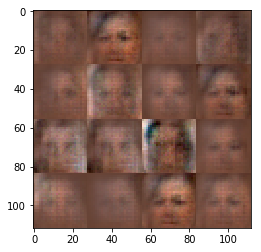

Epoch: 0/1 Batch: 1440 Discriminator loss: 1.5466 Generator loss: 0.6208
Epoch: 0/1 Batch: 1472 Discriminator loss: 1.5392 Generator loss: 0.6221
Epoch: 0/1 Batch: 1504 Discriminator loss: 1.5016 Generator loss: 0.6401
Epoch: 0/1 Batch: 1536 Discriminator loss: 1.4018 Generator loss: 0.7055


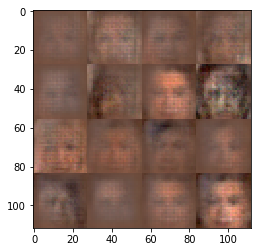

Epoch: 0/1 Batch: 1568 Discriminator loss: 1.4738 Generator loss: 0.6520
Finished training
Epoch: 0/1 Batch: 1582 Discriminator loss: 1.4712 Generator loss: 0.6593


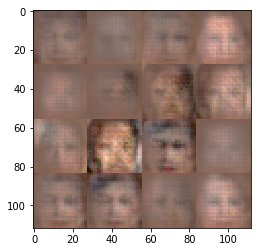

In [52]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.